### **Insall nessaray libraries and packages**

In [ ]:
!pip install utils

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline
import pandas as pd

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [ ]:
!pip install livelossplot

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


In [ ]:
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [ ]:
from keras.utils import to_categorical
from sklearn.utils import shuffle

**Load the dataset**

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/FER_2013/train/'
TEST_DIR = '/content/drive/MyDrive/FER_2013/test/'

**Read Images from the data path**

In [ ]:
import cv2

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/FER_2013/train/'
data_dir_sequence = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

img_data_list = []
emotion_counts_tr = {}

for dataset in data_dir_sequence:
    img_list = os.listdir(os.path.join(TRAIN_DIR, dataset))
    count = len(img_list)
    emotion_counts_tr[dataset] = count
    print('Loaded {} images for the dataset-{}\n'.format(count, dataset))
    for img in img_list:
        input_img = cv2.imread(os.path.join(TRAIN_DIR, dataset, img))
        if input_img is not None:
            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY) #it converts the image to grayscale
            # input_img = cv2.equalizeHist(input_img)  # Apply histogram equalization
            img_data_list.append(input_img)
        else:
            print(f"Failed to read image: {img}")

img_data_train = np.array(img_data_list)
img_data_train = img_data_train.astype('float32')
img_data_train = img_data_train / 255


print("Emotion Counts:")
for emotion, count in emotion_counts_tr.items():
    print("{}: {}".format(emotion, count))


Loaded 3995 images for the dataset-angry

Loaded 436 images for the dataset-disgust

Loaded 4097 images for the dataset-fear

Loaded 4872 images for the dataset-happy

Loaded 4930 images for the dataset-neutral

Loaded 4830 images for the dataset-sad

Emotion Counts:
angry: 3995
disgust: 436
fear: 4097
happy: 4872
neutral: 4930
sad: 4830


In [ ]:
img_data_train.shape

(23160, 48, 48)

In [ ]:
TEST_DIR = '/content/drive/MyDrive/FER_2013/test/'
data_dir_sequence = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']


img_data_list = []

emotion_counts_ts = {}

for dataset in data_dir_sequence:
    img_list = os.listdir(os.path.join(TEST_DIR, dataset))
    count = len(img_list)
    emotion_counts_ts[dataset] = count
    print('Loaded {} images for the dataset-{}\n'.format(count, dataset))
    for img in img_list:
        input_img = cv2.imread(os.path.join(TEST_DIR, dataset, img))
        if input_img is not None:
            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            # input_img = cv2.equalizeHist(input_img)  # Apply histogram equalization
            img_data_list.append(input_img)
        else:
            print(f"Failed to read image: {img}")

img_data_test = np.array(img_data_list)
img_data_test = img_data_test.astype('float32')
img_data_test = img_data_test / 255


print("Emotion Counts:")
for emotion, count in emotion_counts_ts.items():
    print("{}: {}".format(emotion, count))


Loaded 958 images for the dataset-angry

Loaded 111 images for the dataset-disgust

Loaded 1024 images for the dataset-fear

Loaded 1774 images for the dataset-happy

Loaded 1233 images for the dataset-neutral

Loaded 1247 images for the dataset-sad

Emotion Counts:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247


In [ ]:

img_data_test.shape

(6347, 48, 48)

**Define the number of classes**

In [ ]:
num_classes = 6
num_of_samples_train = img_data_train.shape[0]
labels_tr = np.ones((num_of_samples_train,),dtype='int64')

labels_tr[0:3995] = 5  #3995 # Angry
labels_tr[3995:4431] = 4  #436 #disgust
labels_tr[4431:8528] = 3   #4097 #fear
labels_tr[8528:13400] = 0  #4872 #happy
labels_tr[13400:18330] = 2 #4930 neutral
labels_tr[18330:] = 1 #4830 #sad
#labels_tr[18230:] = 2  #3171 #suprise

names = ['HAPPY', 'SAD', 'NEUTRAL', 'FEAR', 'DISGUST', 'ANGRY']

def getLabel(id):
    return ['HAPPY','SAD','NEUTRAL','FEAR','DISGUST','ANGRY'][id]

In [ ]:
label_counts_tr = np.bincount(labels_tr)

# Print the count of each label
for i, count in enumerate(label_counts_tr):
    label_name = getLabel(i)
    print("{}: {}".format(label_name, count))

HAPPY: 4872
SAD: 4830
NEUTRAL: 4930
FEAR: 4097
DISGUST: 436
ANGRY: 3995


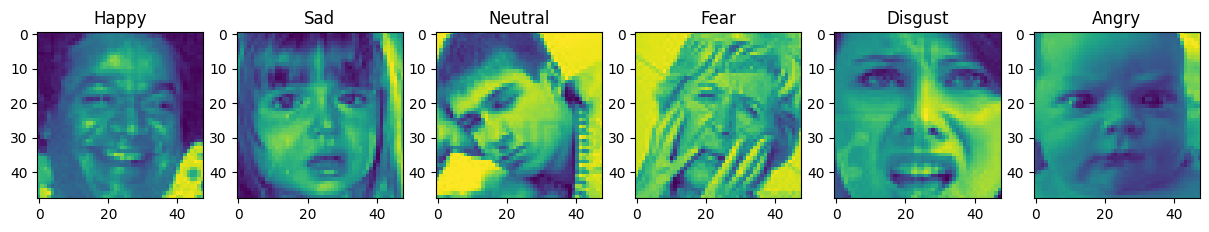

In [ ]:
import matplotlib.pyplot as plt

# Get index of images representing each expression
happy_idx = np.where(labels_tr == 0)[0][0]
sad_idx = np.where(labels_tr == 1)[0][0]
neutral_idx = np.where(labels_tr == 2)[0][0]
fear_idx = np.where(labels_tr == 3)[0][0]
disgust_idx = np.where(labels_tr == 4)[0][0]
angry_idx = np.where(labels_tr == 5)[0][0]

# Plotting the images
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
axs[0].imshow(img_data_train[happy_idx])
axs[0].set_title("Happy")
axs[1].imshow(img_data_train[sad_idx])
axs[1].set_title("Sad")
axs[2].imshow(img_data_train[neutral_idx])
axs[2].set_title("Neutral")
axs[3].imshow(img_data_train[fear_idx])
axs[3].set_title("Fear")
axs[4].imshow(img_data_train[disgust_idx])
axs[4].set_title("Disgust")
axs[5].imshow(img_data_train[angry_idx])
axs[5].set_title("Angry")

plt.show()


In [ ]:
label_id = 1
label_name = getLabel(label_id)
print(label_name)  # Output: sad

SAD


In [ ]:
num_classes = 6

num_of_samples_te = img_data_test.shape[0]
labels_te = np.ones((num_of_samples_te,),dtype='int64')

labels_te[0:958]=5 #958 #Angry
labels_te[958:1069]=4 #111 #disgust
labels_te[1069:2093]=3 #1024 #fear
labels_te[2093:3867]=0 #1774 #happy
labels_te[3867:5100] =2 #1233 neutral
labels_te[5100:]=1 #1247 #sad
#labels_te[5114:]=2 #831 #suprise


names = ['HAPPY', 'SAD', 'NEUTRAL', 'FEAR', 'DISGUST', 'ANGRY']

def getLabel(id):
    return ['HAPPY', 'SAD', 'NEUTRAL', 'FEAR', 'DISGUST', 'ANGRY'][id]

In [ ]:
label_counts_te = np.bincount(labels_te)

# Print the count of each label
for i, count in enumerate(label_counts_te):
    label_name = getLabel(i)
    print("{}: {}".format(label_name, count))

HAPPY: 1774
SAD: 1247
NEUTRAL: 1233
FEAR: 1024
DISGUST: 111
ANGRY: 958


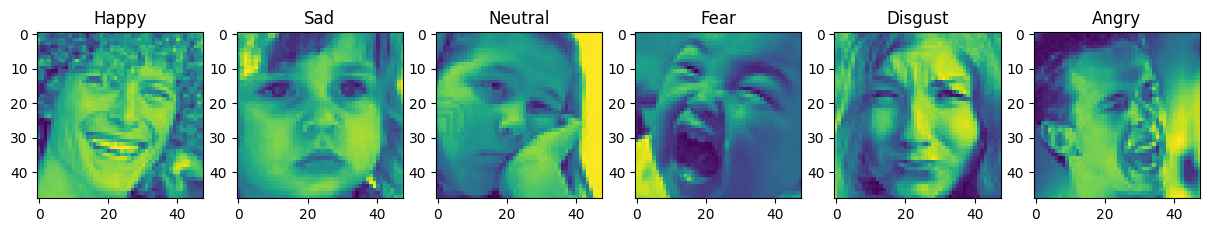

In [ ]:
import matplotlib.pyplot as plt

# Get index of images representing each expression
happy_idx = np.where(labels_te == 0)[0][0]
sad_idx = np.where(labels_te == 1)[0][0]
neutral_idx = np.where(labels_te == 2)[0][0]
fear_idx = np.where(labels_te == 3)[0][0]
disgust_idx = np.where(labels_te == 4)[0][0]
angry_idx = np.where(labels_te == 5)[0][0]

# Plotting the images
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
axs[0].imshow(img_data_test[happy_idx])
axs[0].set_title("Happy")
axs[1].imshow(img_data_test[sad_idx])
axs[1].set_title("Sad")
axs[2].imshow(img_data_test[neutral_idx])
axs[2].set_title("Neutral")
axs[3].imshow(img_data_test[fear_idx])
axs[3].set_title("Fear")
axs[4].imshow(img_data_test[disgust_idx])
axs[4].set_title("Disgust")
axs[5].imshow(img_data_test[angry_idx])
axs[5].set_title("Angry")

plt.show()


**Dataset Distribution**

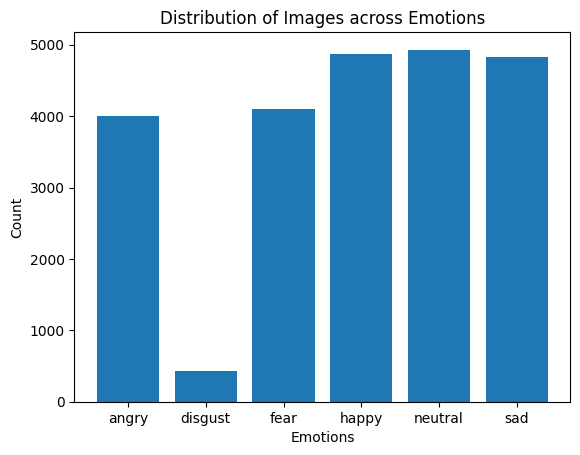

In [ ]:
emotions_tr = list(emotion_counts_tr.keys())
counts_tr = list(emotion_counts_tr.values())

# Create a bar chart
plt.bar(emotions_tr, counts_tr)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Images across Emotions')
plt.show()

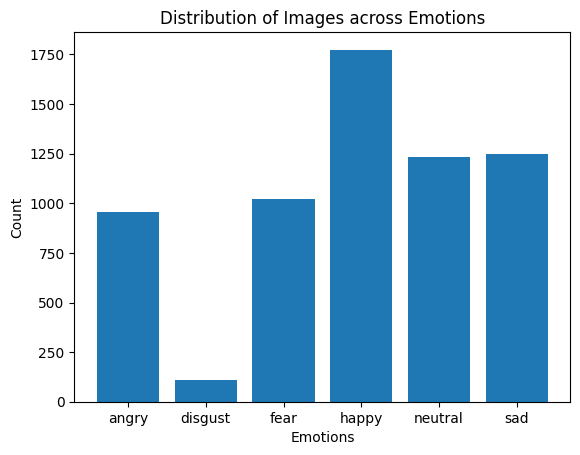

In [ ]:
emotions_ts = list(emotion_counts_ts.keys())
counts_ts = list(emotion_counts_ts.values())

# Create a bar chart
plt.bar(emotions_ts, counts_ts)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Images across Emotions')
plt.show()

**Convert the class label to one-hot encoding**

In [ ]:
#convert class labels to on-hot encoding# conve
Y_tr = to_categorical(labels_tr, num_classes)

In [ ]:
class_index1 = 3800
class_index2 = 4000
class_index3 = 5000
class_index4 = 10000
class_index5 = 18233

one_hot_label1 = Y_tr[class_index1]
one_hot_label2 = Y_tr[class_index2]
one_hot_label3 = Y_tr[class_index3]
one_hot_label4 = Y_tr[class_index4]
one_hot_label5 = Y_tr[class_index5]

print("Previous label:", labels_tr[class_index1])
print("One-hot encoded label:", one_hot_label1)

print("Previous label:", labels_tr[class_index2])
print("One-hot encoded label:", one_hot_label2)

print("Previous label:", labels_tr[class_index3])
print("One-hot encoded label:", one_hot_label3)

print("Previous label:", labels_tr[class_index4])
print("One-hot encoded label:", one_hot_label4)

print("Previous label:", labels_tr[class_index5])
print("One-hot encoded label:", one_hot_label5)


Previous label: 5
One-hot encoded label: [0. 0. 0. 0. 0. 1.]
Previous label: 4
One-hot encoded label: [0. 0. 0. 0. 1. 0.]
Previous label: 3
One-hot encoded label: [0. 0. 0. 1. 0. 0.]
Previous label: 0
One-hot encoded label: [1. 0. 0. 0. 0. 0.]
Previous label: 2
One-hot encoded label: [0. 0. 1. 0. 0. 0.]


In [ ]:
#Shuffle the dataset
x_train,y_train = shuffle(img_data_train,Y_tr, random_state=2)

In [ ]:
X_train = x_train
Y_train = y_train

In [ ]:
# convert class labels to on-hot encoding# conve
Y_te = to_categorical(labels_te, num_classes)

In [ ]:
class_index1 = 900
class_index2 = 1000
class_index3 = 2000
class_index4 = 3000
class_index5 = 5200

one_hot_label = Y_te[class_index1]
one_hot_label = Y_te[class_index2]
one_hot_label = Y_te[class_index3]
one_hot_label = Y_te[class_index4]
one_hot_label = Y_te[class_index5]

print("Previous label:", labels_tr[class_index1])
print("One-hot encoded label:", one_hot_label1)

print("Previous label:", labels_tr[class_index2])
print("One-hot encoded label:", one_hot_label2)

print("Previous label:", labels_tr[class_index3])
print("One-hot encoded label:", one_hot_label3)

print("Previous label:", labels_tr[class_index4])
print("One-hot encoded label:", one_hot_label4)

print("Previous label:", labels_tr[class_index5])
print("One-hot encoded label:", one_hot_label5)

Previous label: 5
One-hot encoded label: [0. 0. 0. 0. 0. 1.]
Previous label: 5
One-hot encoded label: [0. 0. 0. 0. 1. 0.]
Previous label: 5
One-hot encoded label: [0. 0. 0. 1. 0. 0.]
Previous label: 5
One-hot encoded label: [1. 0. 0. 0. 0. 0.]
Previous label: 3
One-hot encoded label: [0. 0. 1. 0. 0. 0.]


In [ ]:
#Shuffle the dataset
x_test,y_test = shuffle(img_data_test,Y_te, random_state=2)

In [ ]:
X_test = x_test
Y_test = y_test

In [ ]:
print(X_train.shape , X_test.shape, Y_train.shape ,Y_test.shape)

(23160, 48, 48) (6347, 48, 48) (23160, 6) (6347, 6)


# **Handling imbalncing**

In [ ]:
from sklearn.utils import class_weight

**Class weights**

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(labels_tr),
                                        y = labels_tr
                                    )
class_weights = dict(zip(np.unique(labels_tr), class_weights))
class_weights

{0: 0.7922824302134647,
 1: 0.7991718426501035,
 2: 0.7829614604462475,
 3: 0.9421527947278496,
 4: 8.853211009174313,
 5: 0.9662077596996246}

In [ ]:
# X_train = np.stack((X_train,)*3, axis = -1)
# X_test = np.stack((X_test,)*3, axis = -1)

In [ ]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

In [ ]:
print(X_train.shape , X_test.shape, Y_train.shape ,Y_test.shape)

(23160, 48, 48, 1) (6347, 48, 48, 1) (23160, 6) (6347, 6)


**Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        samplewise_std_normalization=False,  # divide each input by its std
                        zca_whitening=False,
                        rotation_range=20,
                        shear_range = 20,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True,
                        vertical_flip=False)


balanced_gen = data_generator.flow(X_train, Y_train,)

**Learning Rate Scheduler**

# **Model Buliding**

In [ ]:
from keras import layers
from keras.models import Sequential
from keras.regularizers import l2  # Import l2 function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense, Input, Add ,AveragePooling2D
from keras.models import Model
from keras.initializers import glorot_uniform



In [ ]:
batch_size = 32
num_epochs = 150
input_shape = (48, 48, 3)
verbose = 1
num_classes = 6
base_path = './model/'
l2_regularization=0.01

In [ ]:
filepath = '/content/drive/MyDrive/Reserch/best_model_cifar10_trlearninnnn6g.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [ ]:
# trained_models_path = base_path + '_mini_XCEPTION'
# model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
# model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)

In [ ]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

patience = 25

early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/2), verbose=1)


callbacks = [checkpoint,early_stop,reduce_lr]

In [ ]:
pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
def identity_block(X, f, filters, stage, block,dropout_rate=0.2):
    """
    Implementation of the identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Activation('relu')(X)
    X = Dropout(dropout_rate)(X)  # Add dropout layer


    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2,dropout_rate=0.2):
    """
    Implementation of the convolutional block4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b',padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Activation('relu')(X)
    X = Dropout(dropout_rate)(X)  # Add dropout layer

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)

    return X

In [ ]:
def Net50(input_shape = (48,48,1), classes = 6 , dropout_rate=0.2):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    #X = ZeroPadding2D((1, 1))(X_input)
    X = X_input
    # Stage 1

    X = Conv2D(8, (3, 3), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    # removed maxpool
    #X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1,dropout_rate=dropout_rate)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')


    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2,dropout_rate=dropout_rate)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2,dropout_rate=dropout_rate)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2,dropout_rate=dropout_rate)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL .
    X = AveragePooling2D((2,2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(512, activation = 'relu', name='fc1024' , kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X, name='Net50')

    return model

In [ ]:
from keras.optimizers import Adam, SGD
model = Net50(input_shape = (48, 48, 1), classes = 6,dropout_rate=0.2)
optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "Net50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 46, 46, 8)    80          ['input_1[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 46, 46, 8)    32          ['conv1[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 46, 46, 8)    0           ['bn_conv1[0][0]']               
                                                                                              

In [ ]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [ ]:
history = model.fit(balanced_gen, steps_per_epoch=len(X_train) /batch_size, class_weight=class_weights,epochs=num_epochs, verbose=1, callbacks=callbacks,validation_data= (X_test, Y_test))

Epoch 1/150
723/723 [============================>.] - ETA: 0s - loss: 2.0206 - accuracy: 0.1899
Epoch 1: val_accuracy improved from -inf to 0.23870, saving model to /content/drive/MyDrive/Reserch/best_model_cifar10_trlearning.hdf5
723/723 [==============================] - 54s 53ms/step - loss: 2.0199 - accuracy: 0.1900 - val_loss: 1.7636 - val_accuracy: 0.2387 - lr: 5.0000e-04
Epoch 2/150
724/723 [==============================] - ETA: 0s - loss: 1.7773 - accuracy: 0.2144
Epoch 2: val_accuracy did not improve from 0.23870
723/723 [==============================] - 36s 50ms/step - loss: 1.7773 - accuracy: 0.2144 - val_loss: 1.7776 - val_accuracy: 0.2023 - lr: 5.0000e-04
Epoch 3/150
723/723 [============================>.] - ETA: 0s - loss: 1.7599 - accuracy: 0.2263
Epoch 3: val_accuracy did not improve from 0.23870
723/723 [==============================] - 36s 50ms/step - loss: 1.7594 - accuracy: 0.2264 - val_loss: 1.7812 - val_accuracy: 0.2045 - lr: 5.0000e-04
Epoch 4/150
723/723 [=

# **Train the model**

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)

199/199 [==============================] - 2s 11ms/step - loss: 0.9559 - accuracy: 0.6606


**Prediction results**

In [ ]:
# Assuming you have a trained model named 'model' and training data X_train and corresponding labels Y_train

# Define the emotion label mapping
label_mapping = {
    0: "happy",
    1: "sad",
    2: "neutral",
    3: "fear",
    4: "disgust",
    5: "angry"
}

# Make predictions on the training data
Y_pred = model.predict(X_train)

# Select a few examples to display
num_examples = 10
indices = np.random.randint(0, len(X_train), num_examples)

# Display the predicted and actual labels for the selected examples
for index in indices:
    predicted_label = np.argmax(Y_pred[index])  # Get the index of the predicted class with the highest probability
    actual_label = np.argmax(Y_train[index])  # Get the index of the actual class
    predicted_emotion = label_mapping[predicted_label]
    actual_emotion = label_mapping[actual_label]
    print("Example {}: Predicted label = {}, Actual label = {}".format(index, predicted_emotion, actual_emotion))


724/724 [==============================] - 7s 9ms/step
Example 7751: Predicted label = angry, Actual label = angry
Example 1496: Predicted label = fear, Actual label = fear
Example 7539: Predicted label = disgust, Actual label = disgust
Example 18158: Predicted label = angry, Actual label = angry
Example 6419: Predicted label = neutral, Actual label = angry
Example 18018: Predicted label = happy, Actual label = happy
Example 15401: Predicted label = neutral, Actual label = neutral
Example 6840: Predicted label = sad, Actual label = sad
Example 593: Predicted label = happy, Actual label = happy
Example 14569: Predicted label = neutral, Actual label = fear


In [ ]:
def plotting_epochs(training_, validation_, lossOrAccu):
  plt.figure(figsize=[6,4])
  plt.plot(training_, 'black', linewidth=2.0)
  plt.plot(validation_, 'blue', linewidth=2.0)
  plt.legend(['Training '+lossOrAccu, 'Validation '+lossOrAccu], fontsize=14)
  plt.xlabel('Epochs', fontsize=10)
  plt.ylabel(lossOrAccu, fontsize=10)
  plt.title(lossOrAccu+' Curves', fontsize=12)

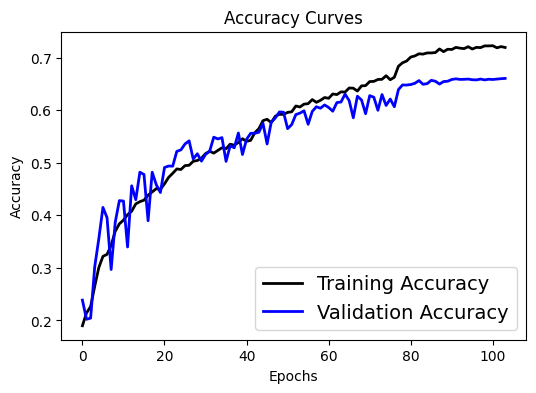

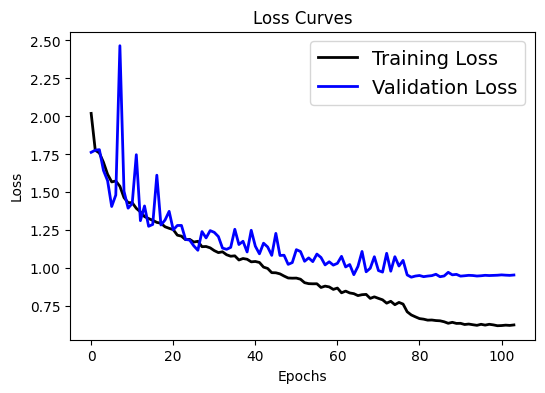

In [ ]:
plotting_epochs(history.history['accuracy'], history.history['val_accuracy'], "Accuracy")
plotting_epochs(history.history['loss'], history.history['val_loss'], "Loss")

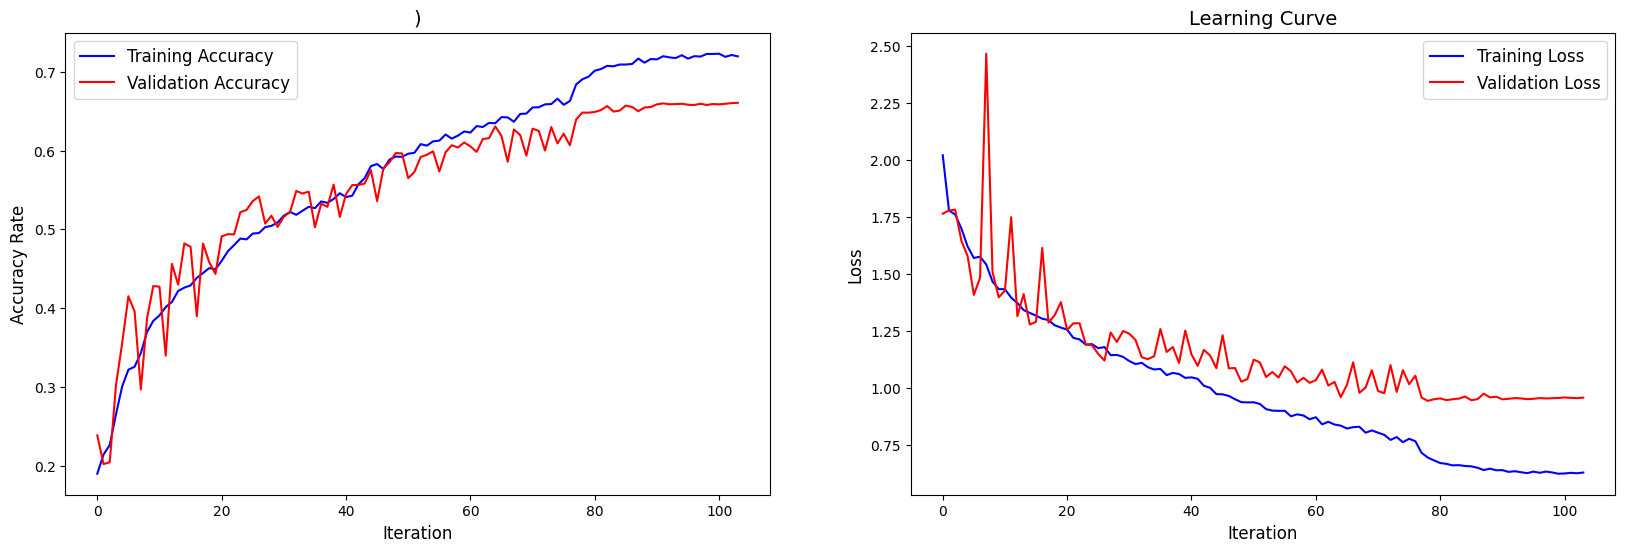

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title(')',fontsize=14)

ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

199/199 [==============================] - 2s 9ms/step


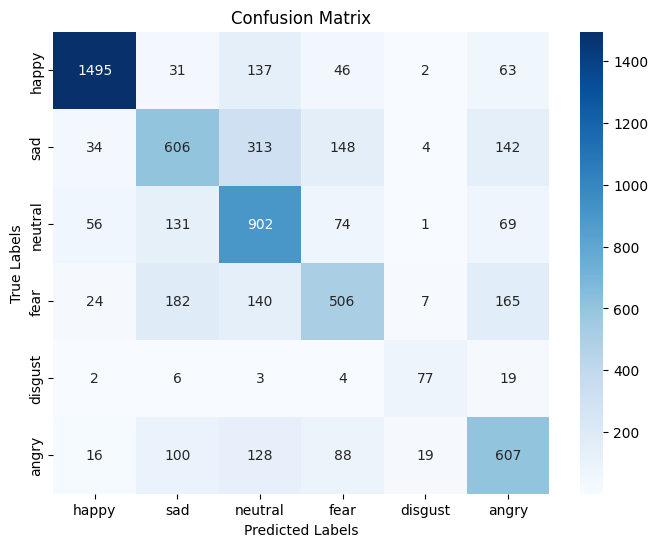

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have a trained model named 'model' and test data X_test with corresponding true labels Y_test

# Make predictions on the test data
Y_pred = model.predict(X_test)

# Get the class labels with the highest probability for each prediction
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels for the test data
y_true = np.argmax(Y_test, axis=1)

# Assuming you have the true labels (y_true) and predicted labels (y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a list of class labels
class_labels = ['happy', 'sad', 'neutral', 'fear', 'disgust', 'angry']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:

from sklearn.metrics import classification_report

# Assuming you have a trained model named 'model' and test data X_test and corresponding labels Y_test

# Make predictions on the test data
Y_pred = model.predict(X_test)
predicted_labels = np.argmax(Y_pred, axis=1)

# Generate classification report
report = classification_report(np.argmax(Y_test, axis=1), predicted_labels)

print(report)


199/199 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1774
           1       0.57      0.49      0.53      1247
           2       0.56      0.73      0.63      1233
           3       0.58      0.49      0.54      1024
           4       0.70      0.69      0.70       111
           5       0.57      0.63      0.60       958

    accuracy                           0.66      6347
   macro avg       0.65      0.65      0.64      6347
weighted avg       0.67      0.66      0.66      6347



In [ ]:
# import dlib
# from PIL import Image
# from skimage import io, color
# import matplotlib.pyplot as plt

# def detect_faces(image):
#     # Create a face detector
#     face_detector = dlib.get_frontal_face_detector()

#     # Convert image to RGB if it's in a different format
#     if image.ndim == 2:
#         # Grayscale image
#         image = color.gray2rgb(image)
#     elif image.ndim == 4:
#         # RGBA image
#         image = image[..., :3]

#     # Run detector and get bounding boxes of the faces in the image
#     detected_faces = face_detector(image, 1)
#     face_frames = [(x.left(), x.top(), x.right(), x.bottom()) for x in detected_faces]

#     return face_frames

# # Load image
# img_path = '/content/drive/MyDrive/photos/S057_001_00000019.png'
# image = io.imread(img_path)

# # Detect faces
# detected_faces = detect_faces(image)
# tab_faces = []
# # Crop faces and plot
# for n, face_rect in enumerate(detected_faces):
#     face = Image.fromarray(image).crop(face_rect)
#     tab = np.asarray(face)
#     tab_faces.append(tab)
#     plt.subplot(1, len(detected_faces), n+1)
#     plt.axis('off')
#     plt.imshow(face)

# plt.show()


In [ ]:
# image_to_predict = np.asarray(face)
# img = cv2.resize(image_to_predict,(48,48),1)

In [ ]:
# inv_dic = {
#     0: 'happy',
#     1: 'sad',
#     2: 'suprise',
#     3: 'fear',
#     4: 'disgust',
#     5: 'angry'
#     # Add more class labels and indices as needed
# }


In [ ]:
# tab = []
# tab.append(img)
# tab = np.array(tab)
# print(inv_dic[np.argmax(model.predict(tab))])
# # plt.imshow(tab[0],cmap = plt.cm.binary)

In [ ]:
# for img in tab_faces :
#   img = img = cv2.resize(img,(48,48),3)
#   tab = []
#   tab.append(img)
#   tab = np.array(tab)
#   print(inv_dic[np.argmax(model.predict(tab))])

In [ ]:
# # Load and display the original image
# original_image = Image.fromarray(image)
# plt.figure()
# plt.imshow(original_image)
# plt.axis('off')
# plt.show()

In [ ]:
import dlib
from PIL import Image
from skimage import io, color
import matplotlib.pyplot as plt

def detect_faces(image):
    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Convert image to RGB if it's in a different format
    if image.ndim == 2:
        # Grayscale image
        image = color.gray2rgb(image)
    elif image.ndim == 4:
        # RGBA image
        image = image[..., :3]

    # Run detector and get bounding boxes of the faces in the image
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(), x.right(), x.bottom()) for x in detected_faces]

    return face_frames

# Load image
img_path = '/content/drive/MyDrive/photos/S999_001_00000018.png'
image = io.imread(img_path)

# Detect faces
detected_faces = detect_faces(image)
tab_faces = []
# Crop faces and plot
for n, face_rect in enumerate(detected_faces):
    face = Image.fromarray(image).crop(face_rect)
    tab = np.asarray(face)
    tab_faces.append(tab)
    plt.subplot(1, len(detected_faces), n+1)
    plt.axis('off')
    plt.imshow(face)

plt.show()

In [ ]:
image_to_predict = np.asarray(face)
img = cv2.resize(image_to_predict,(48,48),1)

In [ ]:
inv_dic = {
    0: 'happy',
    1: 'sad',
    2: 'neutral',
    3: 'fear',
    4: 'disgust',
    5: 'angry'
    # Add more class labels and indices as needed
}


In [ ]:
tab = []
tab.append(img)
tab = np.array(tab)
print(inv_dic[np.argmax(model.predict(tab))])
# plt.imshow(tab[0],cmap = plt.cm.binary)

In [ ]:
for img in tab_faces :
  img = img = cv2.resize(img,(48,48),3)
  tab = []
  tab.append(img)
  tab = np.array(tab)
  print(inv_dic[np.argmax(model.predict(tab))])

In [ ]:
# # Load and display the original image
# original_image = Image.fromarray(image)
# plt.figure()
# plt.imshow(original_image)
# plt.axis('off')
# plt.show()